# Introduction to GANs with Tensorflow <a class="tocSkip">

[Tomas Beuzen](https://tomasbeuzen.github.io/) (May 2020)
    
---    

# Introduction

This notebook provides a very simple example for buidling a GAN with Tensorflow.

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16,
                     'axes.labelweight': 'bold',
                     'figure.figsize': (8,6)})

# A simple GAN

## Data preparation

- First we'll load in the mnist digits dataset

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train[y_train == 0]  # we'll just work with 0's for now
y_train = y_train[y_train == 0]

Text(0.5, 1.0, 'This is a 0')

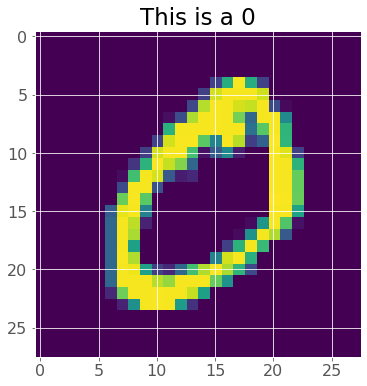

In [4]:
n = 0
plt.imshow(X_train[n])
plt.title(f"This is a {y_train[n]}")

## Define the models

In [5]:
np.random.seed(42)
tf.random.set_seed(42)
INPUT_SIZE = 100

### Generator

- The generator accepts noise as an input and produce an image
- The noise dimensions (also called the "latent dimension" can be anything - but is usually set to 100 in the GAN literature)
- The goal is to train the generator to produce images that are so realistic, the discriminator cannot tell they are fake
- We will define a very simple generator model here composed of a few dense layers

In [6]:
generator = tf.keras.Sequential()
generator.add(layers.Dense(100, activation="relu", input_shape=[INPUT_SIZE]))
generator.add(layers.Dense(150, activation='relu'))
generator.add(layers.Dense(784, activation="sigmoid")) # 28*28 = 784
generator.add(layers.Reshape([28,28]))

In [7]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dense_1 (Dense)              (None, 150)               15150     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               118384    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0         
Total params: 143,634
Trainable params: 143,634
Non-trainable params: 0
_________________________________________________________________


### Discriminator

- The discriminator's job is to classify an image as fake or real
- It takes an image as input but only outputs a classification (0 or 1)

In [8]:
discriminator = tf.keras.Sequential()
discriminator.add(layers.Flatten(input_shape=[28,28]))
discriminator.add(layers.Dense(150, activation='relu'))
discriminator.add(layers.Dense(100, activation='relu'))
discriminator.add(layers.Dense(1, activation="sigmoid"))
discriminator.compile(loss="binary_crossentropy", optimizer="adam")

In [9]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 150)               117750    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               15100     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 132,951
Trainable params: 132,951
Non-trainable params: 0
_________________________________________________________________


### GAN

- The GAN is composed of the generator and discriminator together

In [10]:
GAN = tf.keras.Sequential([generator,
                           discriminator])
discriminator.trainable = False
GAN.compile(loss="binary_crossentropy", optimizer="adam")

## Train the model

- Training will occur in two phases (per batch):
    1. First we train the discriminator to distinguish between fake and real images. We will use the generator to generate some fake images (and give those a label of 0), and combine them with some real images (with a label of 1) to train the discriminator.
    2. With the discriminator trained we now need to train the. In the second phase we generate fake images with the generator but this time give them a label of 1. As these images are passed through the GAN the loss will be very high, because the discriminator will be able to tell the generated images are fake (label 0), but we've given them a label of 1. Therefore, in training, the generator will learn (adjust its weights) to produce more realistic images to reduce this loss.

In [11]:
BUFFER_SIZE = len(X_train)
BATCH_SIZE = 32
EPOCHS = 20

In [12]:
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE,
                                                                                 drop_remainder=True)

In [14]:
# For every epoch
for epoch in range(EPOCHS):
    print(f"Currently on Epoch {epoch + 1}")
    
    # For every batch in the dataset
    for X_batch in dataset:
            
        # Train the discriminator
        # We'll pass in some fake images and some real images to train the discriminator
        noise = tf.random.normal(shape=[BATCH_SIZE, INPUT_SIZE])  # Create some noise
        gen_images = generator(noise)  # Generate fake images based on noise input
        X_fake_vs_real = tf.concat([gen_images,
                                    tf.dtypes.cast(X_batch, tf.float32)],
                                   axis=0)  # Concatenate generated and real images
        y1 = tf.constant([[0.]] * BATCH_SIZE + [[1.]] * BATCH_SIZE)  # aargets are 0 for fakes, 1 for reals
        discriminator.trainable = True
        discriminator.train_on_batch(X_fake_vs_real,
                                     y1)  # Train the discriminator on this batch
        
        # Train the generator
        noise = tf.random.normal(shape=[BATCH_SIZE, INPUT_SIZE])  # Create some noise
        y2 = tf.constant([[1.]] * BATCH_SIZE)  # We want discriminator to belive that fake images are real
        discriminator.trainable = False
        GAN.train_on_batch(noise, y2)  # pass noise to the GAN
                                       # the generator will generate a fake image, but we label it with a 1
                                       # at the begining of training, our trained discriminator will be able to 
                                       # tell the image is fake (label 0) so loss will be high.
                                       # this forces the generator to adjust its weights (train) to produce
                                       # more realistic images that fool the discriminator and reduce the loss.
        
print("TRAINING COMPLETE")            

Currently on Epoch 1
Currently on Epoch 2
Currently on Epoch 3
Currently on Epoch 4
Currently on Epoch 5
Currently on Epoch 6
Currently on Epoch 7
Currently on Epoch 8
Currently on Epoch 9
Currently on Epoch 10
Currently on Epoch 11
Currently on Epoch 12
Currently on Epoch 13
Currently on Epoch 14
Currently on Epoch 15
Currently on Epoch 16
Currently on Epoch 17
Currently on Epoch 18
Currently on Epoch 19
Currently on Epoch 20
Currently on Epoch 21
Currently on Epoch 22
Currently on Epoch 23
Currently on Epoch 24
Currently on Epoch 25
Currently on Epoch 26
Currently on Epoch 27
Currently on Epoch 28
Currently on Epoch 29
Currently on Epoch 30
TRAINING COMPLETE


## Test the model

- We can test our model by generating some random noise and using the generator to generate an image!

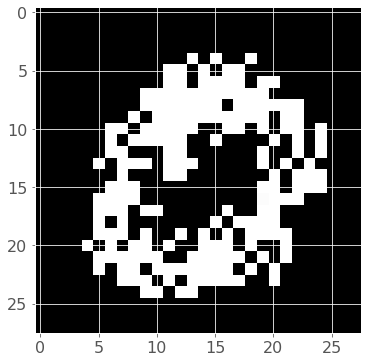

In [16]:
noise = tf.random.normal(shape=[1, INPUT_SIZE])
generated_image = generator(noise)
plt.imshow(generated_image[0], cmap='gray');

- GAN's are very sensitive models
- We typically need the loss of the generator/discriminator/GAN to reduce at a similar rate, otherwise one part of the model will out-compete the other
- One problem with vanilla GANs is that the generator can learn to produce just one type of image all of the time that it knows can fool the discriminator - this is called "mode collapse"
- Try running the cell above multiple times, you might be getting the exact same image over and over!
- We can prevent "mode collapse" by playing with the learning rates of the model or by using [convolutional GANs](convolutional_GAN.ipynb)